In [1]:
# dependencies
import re
import pandas as pd
from plotnine import (
    ggplot,
    aes,
    after_stat,
    geom_bar,
    geom_text
)
import plotnine

In [2]:
# support methods

In [11]:
# main
complaints = pd.read_parquet("../../export/output/complaints.parquet")

In [9]:
complaints.loc[complaints.date_complained.dt.year == 2023].date_complained.dt.month.value_counts()

date_complained
1     34
3     28
4     25
2     19
5     13
6      4
7      2
12     1
Name: count, dtype: int64

# DPA not OCC
The dataset used here includes records processed from both Department of Police Accountability reports and the Office Citizen Complaints reports. 
- DPA began in 2016, so reports from that year onward should all be from DPA
- monthly OCC reports going back to 2005 can be found on the [wayback archive](https://wayback.archive-it.org/org-571/20230120175459/https://sfgov.org/dpa/reports-statistics#2012). For some reason, reports for 2010, 2011, and 2012 are not being scraped well?

### review of fields

In [4]:
[col for col in complaints.columns if 'date' in col]

['date_complained_text',
 'date_completed_text',
 'date_complained',
 'date_completed']

In [5]:
complaints[[col for col in complaints.columns if 'date' in col]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27038 entries, 0 to 27037
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date_complained_text  26827 non-null  object        
 1   date_completed_text   26851 non-null  object        
 2   date_complained       26780 non-null  datetime64[ns]
 3   date_completed        26802 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 845.1+ KB


## range of dates extracted

In [7]:
complaints.date_complained.describe()

count                            26780
mean     2012-08-11 08:43:05.332337408
min                2001-07-17 00:00:00
25%                2007-01-07 12:00:00
50%                2013-10-04 00:00:00
75%                2017-12-01 00:00:00
max                2023-12-12 00:00:00
Name: date_complained, dtype: object

In [8]:
complaints.date_completed.describe()

count                            26802
mean     2013-03-31 10:27:38.562793984
min                2003-12-30 00:00:00
25%                2007-08-14 00:00:00
50%                2014-05-29 00:00:00
75%                2018-06-21 00:00:00
max                2025-05-05 00:00:00
Name: date_completed, dtype: object

In [39]:
complaints.loc[(complaints.date_complained.dt.year >= 2023) & (complaints.date_complained.dt.month >= 9), 
['date_complained', 'date_completed', 'allegation_text']]

,date_complained,date_completed,allegation_text
210,2023-12-12,2023-02-16,SUMMARY OF ALLEGATION #1: The officer failed t...


In [40]:
complaints.loc[(complaints.date_complained.dt.year >= 2023) & (complaints.date_complained.dt.month >= 9), 
['date_complained', 'date_completed', 'allegation_text']].values[0]

array([Timestamp('2023-12-12 00:00:00'), Timestamp('2023-02-16 00:00:00'),
       'SUMMARY OF ALLEGATION #1: The officer failed to prepare an incident report. CATEGORY OF CONDUCT: ND FINDING: NF FINDINGS OF FACT: The complainant stated that officers failed to write an incident report about hi neighbors throwing items against his front door. The complainant failed to provide further information. The date and time of the incident were not provided. The complainant also could not provide names or star numbers of the officers involved. The complainant failed to respond to requests for further information. Without further evidence the allegation can not be investigated. No finding outcomes occur under four circumstances: the complainant did not provide additional requested evidence, the complainant requested a withdrawal of the complaint, the officer could not reasonably be identified, or the officer is no longer with the Department and therefore is no longer ubject to Department discipline

## coverage of formatting method

In [9]:
complaints.date_complained.notna().sum()

26780

In [10]:
complaints.date_complained.notna().sum() / complaints.shape[0]

0.9904578741031141

In [10]:
complaints.date_completed.notna().sum()

25783

In [11]:
complaints.date_completed.notna().sum() / complaints.shape[0]

0.9912344777209642

## OOB datestamps?

In [11]:
assert not any(complaints.date_complained.dt.year > 2023)

In [12]:
assert not any(complaints.date_completed.dt.year > 2023)

AssertionError: 

In [13]:
complaints.date_completed.describe()

count                            26802
mean     2013-03-31 10:27:38.562793984
min                2003-12-30 00:00:00
25%                2007-08-14 00:00:00
50%                2014-05-29 00:00:00
75%                2018-06-21 00:00:00
max                2025-05-05 00:00:00
Name: date_completed, dtype: object

## missing datestamps?

In [14]:
complaints.date_complained.isna().sum()

258

In [18]:
complaints.loc[(complaints.date_complained_text.notna()) & (complaints.date_complained.isna()), 
['date_complained_text', 'pdf_url']].values

array([['06/17/022',
        'https://sf.gov/sites/default/files/2023-03/Openness_report_Jan_23.pdf'],
       ['06/17/022',
        'https://sf.gov/sites/default/files/2023-03/Openness_report_Jan_23.pdf'],
       ['12/01/022',
        'https://sf.gov/sites/default/files/2023-07/Openness%20May.pdf'],
       ['09/21/021',
        'https://sf.gov/sites/default/files/2022-04/DPA_01_22_openness_0.pdf'],
       ['01/027/22',
        'https://sf.gov/sites/default/files/2022-04/DPA_02_22_openness_0.pdf'],
       ['02/1422',
        'https://sf.gov/sites/default/files/2022-06/DPA_05_22_openness_0.pdf'],
       ['043/05/22',
        'https://sf.gov/sites/default/files/2023-04/Openness%20Nov.pdf'],
       ['043/05/22',
        'https://sf.gov/sites/default/files/2023-04/Openness%20Nov.pdf'],
       ['04/06/022',
        'https://sf.gov/sites/default/files/2023-01/openness%20dec.xlsx.pdf'],
       ['04/06/022',
        'https://sf.gov/sites/default/files/2023-01/openness%20dec.xlsx.pdf'],
       [

In [19]:
complaints.date_completed.isna().sum()

236

In [22]:
complaints.loc[(complaints.date_completed_text.notna()) & (complaints.date_completed.isna()), 
['date_completed_text', 'pdf_url']].values

array([['04/06/023',
        'https://sf.gov/sites/default/files/2023-05/Openness%20April.pdf'],
       ['07//02/23',
        'https://sf.gov/sites/default/files/2023-09/July_Openness_0.pdf'],
       ['0/09/22',
        'https://sf.gov/sites/default/files/2022-04/DPA_02_22_openness_0.pdf'],
       ['11/01//22',
        'https://sf.gov/sites/default/files/2023-04/Openness%20Nov.pdf'],
       ['01//11/21',
        'https://sf.gov/sites/default/files/2021-07/DPA_01_21_openness.pdf'],
       ['01//11/21',
        'https://sf.gov/sites/default/files/2021-07/DPA_01_21_openness.pdf'],
       ['03/22/2',
        'https://sf.gov/sites/default/files/2021-07/DPA_03_21_openness.pdf'],
       ['03/22/2',
        'https://sf.gov/sites/default/files/2021-07/DPA_03_21_openness.pdf'],
       ['0708/21',
        'https://sf.gov/sites/default/files/2021-08/DPA_07_21_openness.pdf'],
       ['0708/21',
        'https://sf.gov/sites/default/files/2021-08/DPA_07_21_openness.pdf'],
       ['0708/21',
        

## time to close

In [23]:
complaints.ttc_group.value_counts()

ttc_group
Under 1 year      12495
Under 6 months     4683
Under 3 months     3642
Under 2 years      2989
Under 1 month      2133
Over 2 years        533
NEGATIVE            212
Name: count, dtype: int64

In [24]:
complaints.time_to_complete.describe()

count                          26687
mean     235 days 21:32:41.539326264
std      207 days 16:07:57.380744146
min             -3135 days +00:00:00
25%                100 days 00:00:00
50%                226 days 00:00:00
75%                321 days 00:00:00
max               2805 days 00:00:00
Name: time_to_complete, dtype: object

In [25]:
complaints.loc[complaints.ttc_group.str.contains("month", na=False)].shape[0] / complaints.shape[0]

0.3867889636807456

In [26]:
complaints.loc[complaints.ttc_group.str.contains("year", na=False)].shape[0] / complaints.shape[0]

0.5923884902729492

In [27]:
subset = complaints[['allegation_id', 'year_complained', 'ttc_group']].copy().set_index('allegation_id')
ohe = pd.get_dummies(subset.ttc_group)
df = pd.merge(subset, ohe, on='allegation_id')
df.drop(columns=['ttc_group', 'NEGATIVE'], inplace=True)
gb = df.groupby('year_complained').sum()
gb

,Over 2 years,Under 1 month,Under 1 year,Under 2 years,Under 3 months,Under 6 months
year_complained,,,,,,
2001.0,18,0,0,0,0,0
2002.0,44,0,0,0,0,0
2003.0,36,5,0,39,0,0
2004.0,15,10,983,213,47,136
2005.0,62,159,1343,439,410,485
2006.0,38,158,782,430,312,450
2007.0,0,199,869,296,480,438
2008.0,0,231,1051,70,435,475
2009.0,0,173,438,0,390,482


In [28]:
less = complaints[['year_complained', 'year_completed', 'ttc_group', 'time_to_complete']].dropna()
less = less.loc[less.ttc_group != 'NEGATIVE']
less

,year_complained,year_completed,ttc_group,time_to_complete
0,2021.0,2023.0,Under 2 years,467 days
1,2021.0,2023.0,Under 2 years,467 days
2,2021.0,2023.0,Under 2 years,467 days
3,2021.0,2023.0,Under 2 years,467 days
4,2021.0,2023.0,Under 2 years,467 days
...,...,...,...,...
27033,2005.0,2005.0,Under 3 months,50 days
27034,2005.0,2005.0,Under 3 months,65 days
27035,2005.0,2005.0,Under 3 months,65 days
27036,2005.0,2005.0,Under 3 months,53 days


/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/stats/stat_count.py:70: FutureWarning: The provided callable <function sum at 0x106211b20> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/stats/stat_count.py:70: FutureWarning: The provided callable <function sum at 0x106211b20> is currently using DataFrameGroupBy.sum. In a

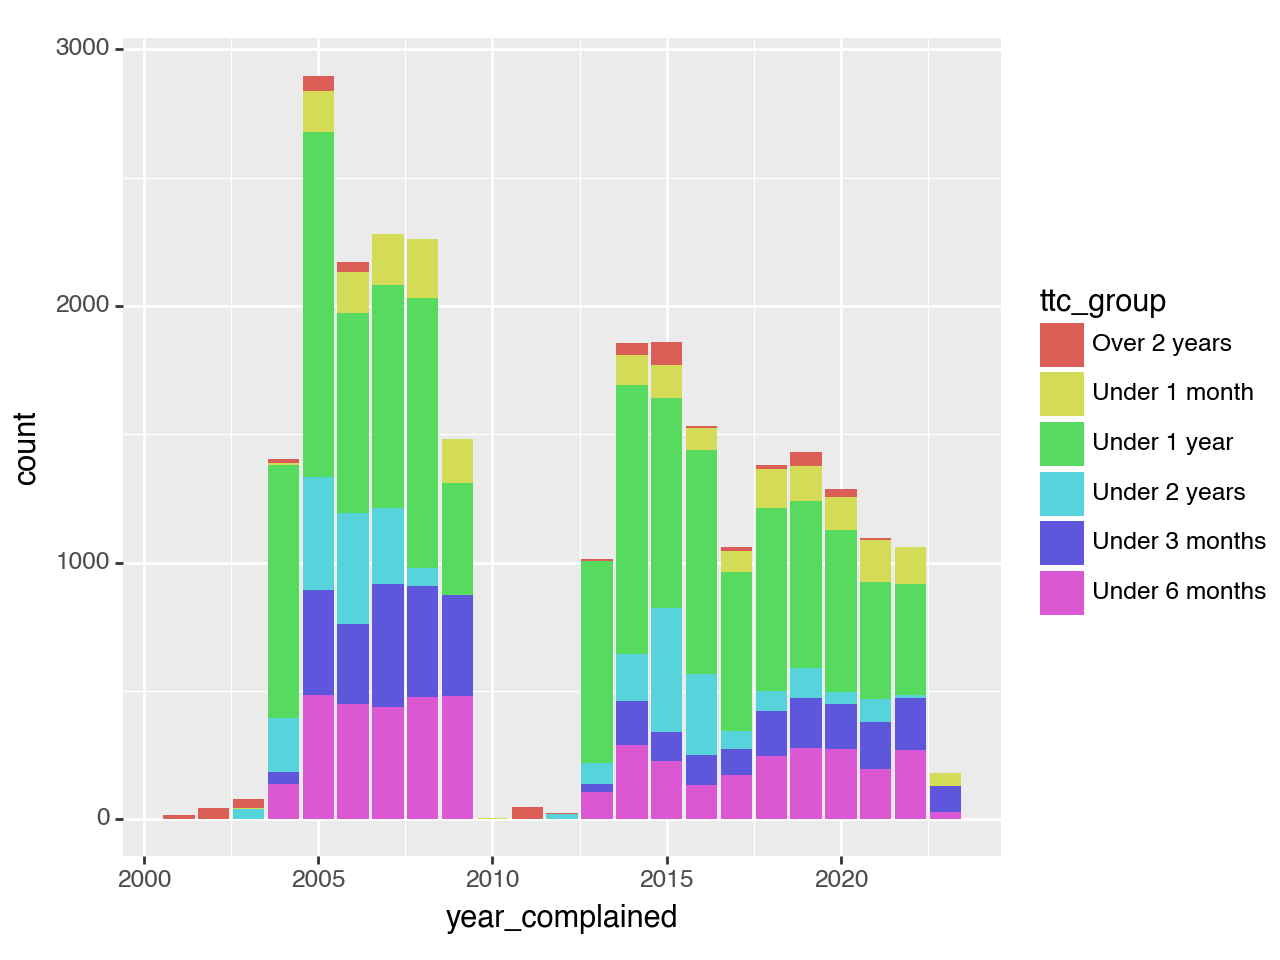

<Figure Size: (640 x 480)>

In [29]:
(ggplot(less.dropna(), aes('year_complained', fill='ttc_group'))
 + geom_bar()
)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/mizani/scale.py:210: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/mizani/scale.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


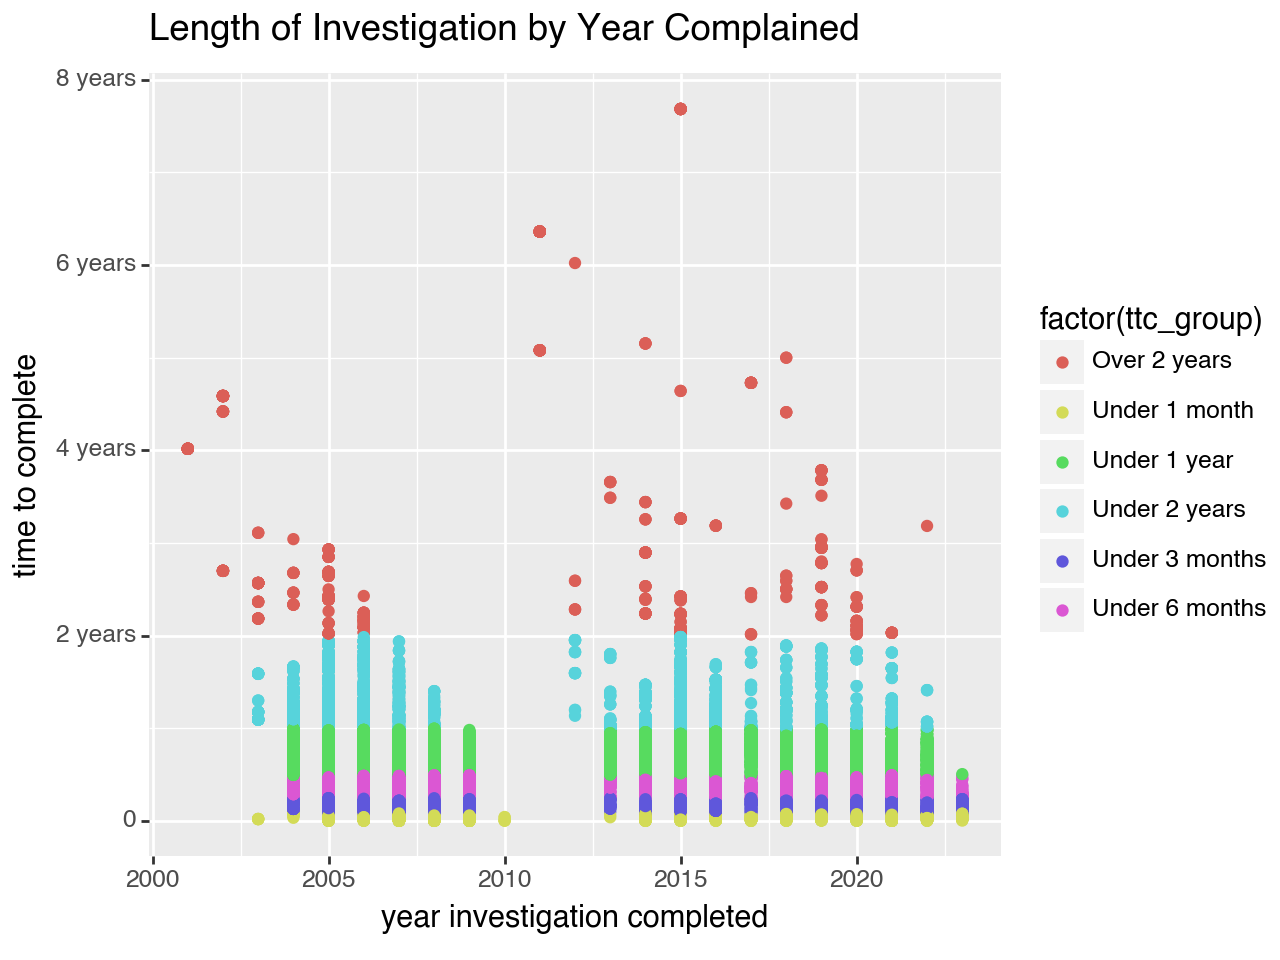

<Figure Size: (640 x 480)>

In [30]:
scatter5 = plotnine.qplot(x="year_complained",y="time_to_complete", data=less, geom="point", color="factor(ttc_group)",
                          xlab="year investigation completed", ylab="time to complete",
                          main="Length of Investigation by Year Complained"
                         )
scatter5

/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/stats/stat_count.py:70: FutureWarning: The provided callable <function sum at 0x106211b20> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/stats/stat_count.py:70: FutureWarning: The provided callable <function sum at 0x106211b20> is currently using DataFrameGroupBy.sum. In a

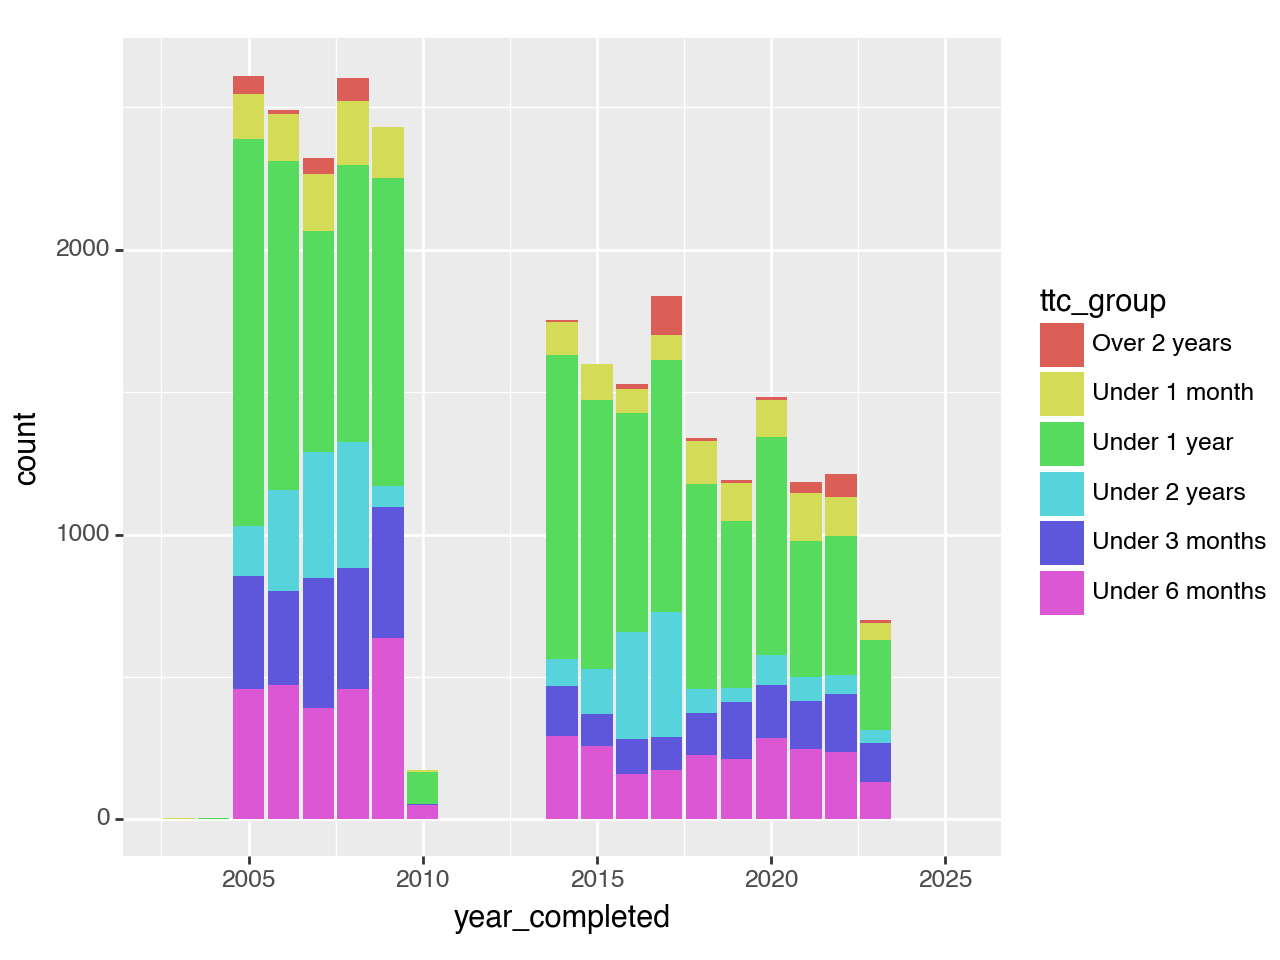

<Figure Size: (640 x 480)>

In [31]:
(ggplot(less.dropna(), aes('year_completed', fill='ttc_group'))
 + geom_bar()
)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/mizani/scale.py:210: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/mizani/scale.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


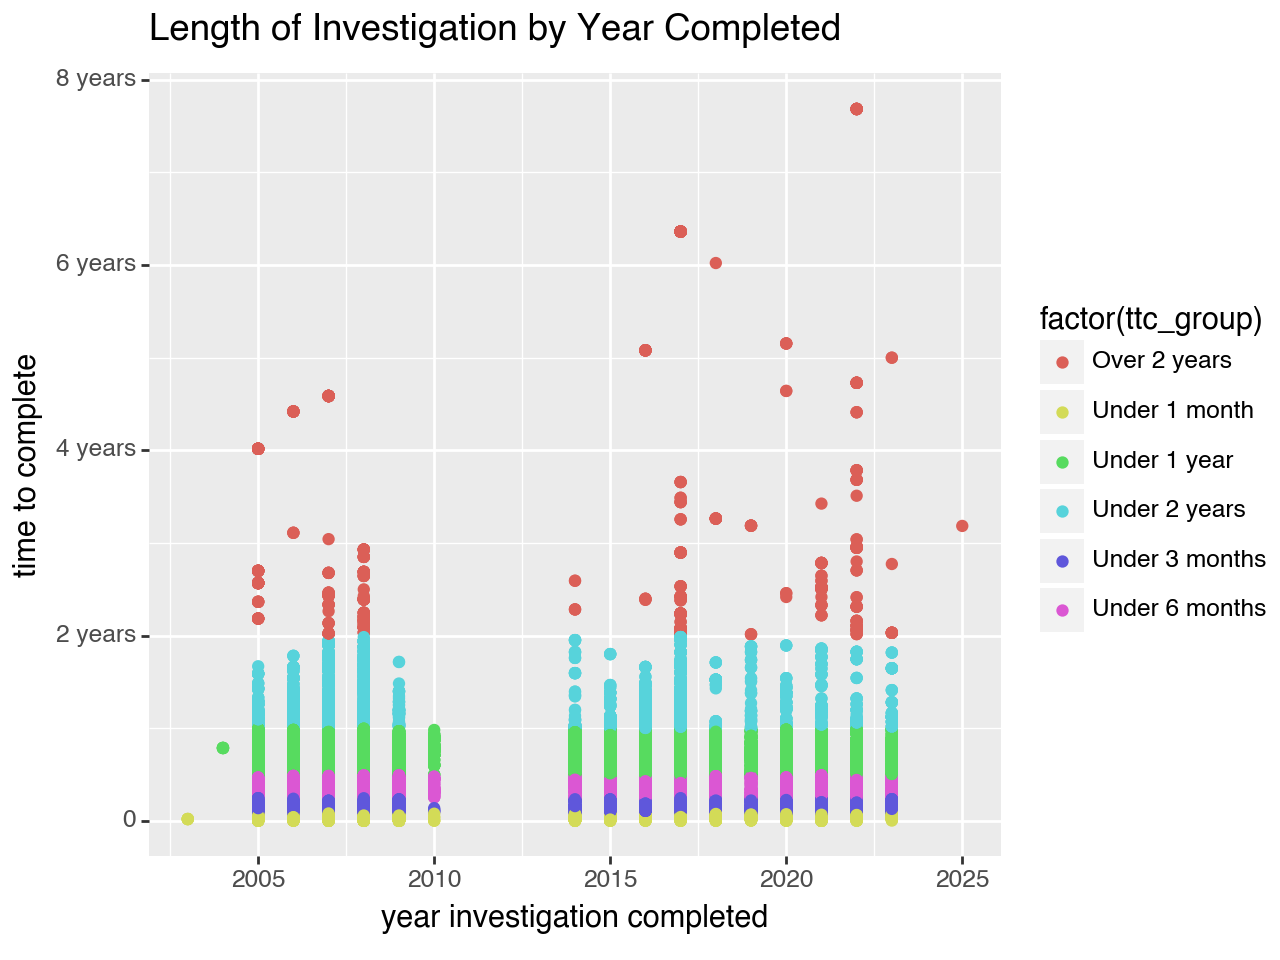

<Figure Size: (640 x 480)>

In [32]:
scatter5 = plotnine.qplot(x="year_completed",y="time_to_complete", data=less, geom="point", color="factor(ttc_group)",
                          xlab="year investigation completed", ylab="time to complete",
                          main="Length of Investigation by Year Completed"
                         )
scatter5

/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/scales/scale_size.py:49: PlotnineWarning: Using size for a discrete variable is not advised.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:289: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/mizani/scale.py:210: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/mizani/scale.py:223: FutureWarning: is_categorical_dtype is deprecated and wil

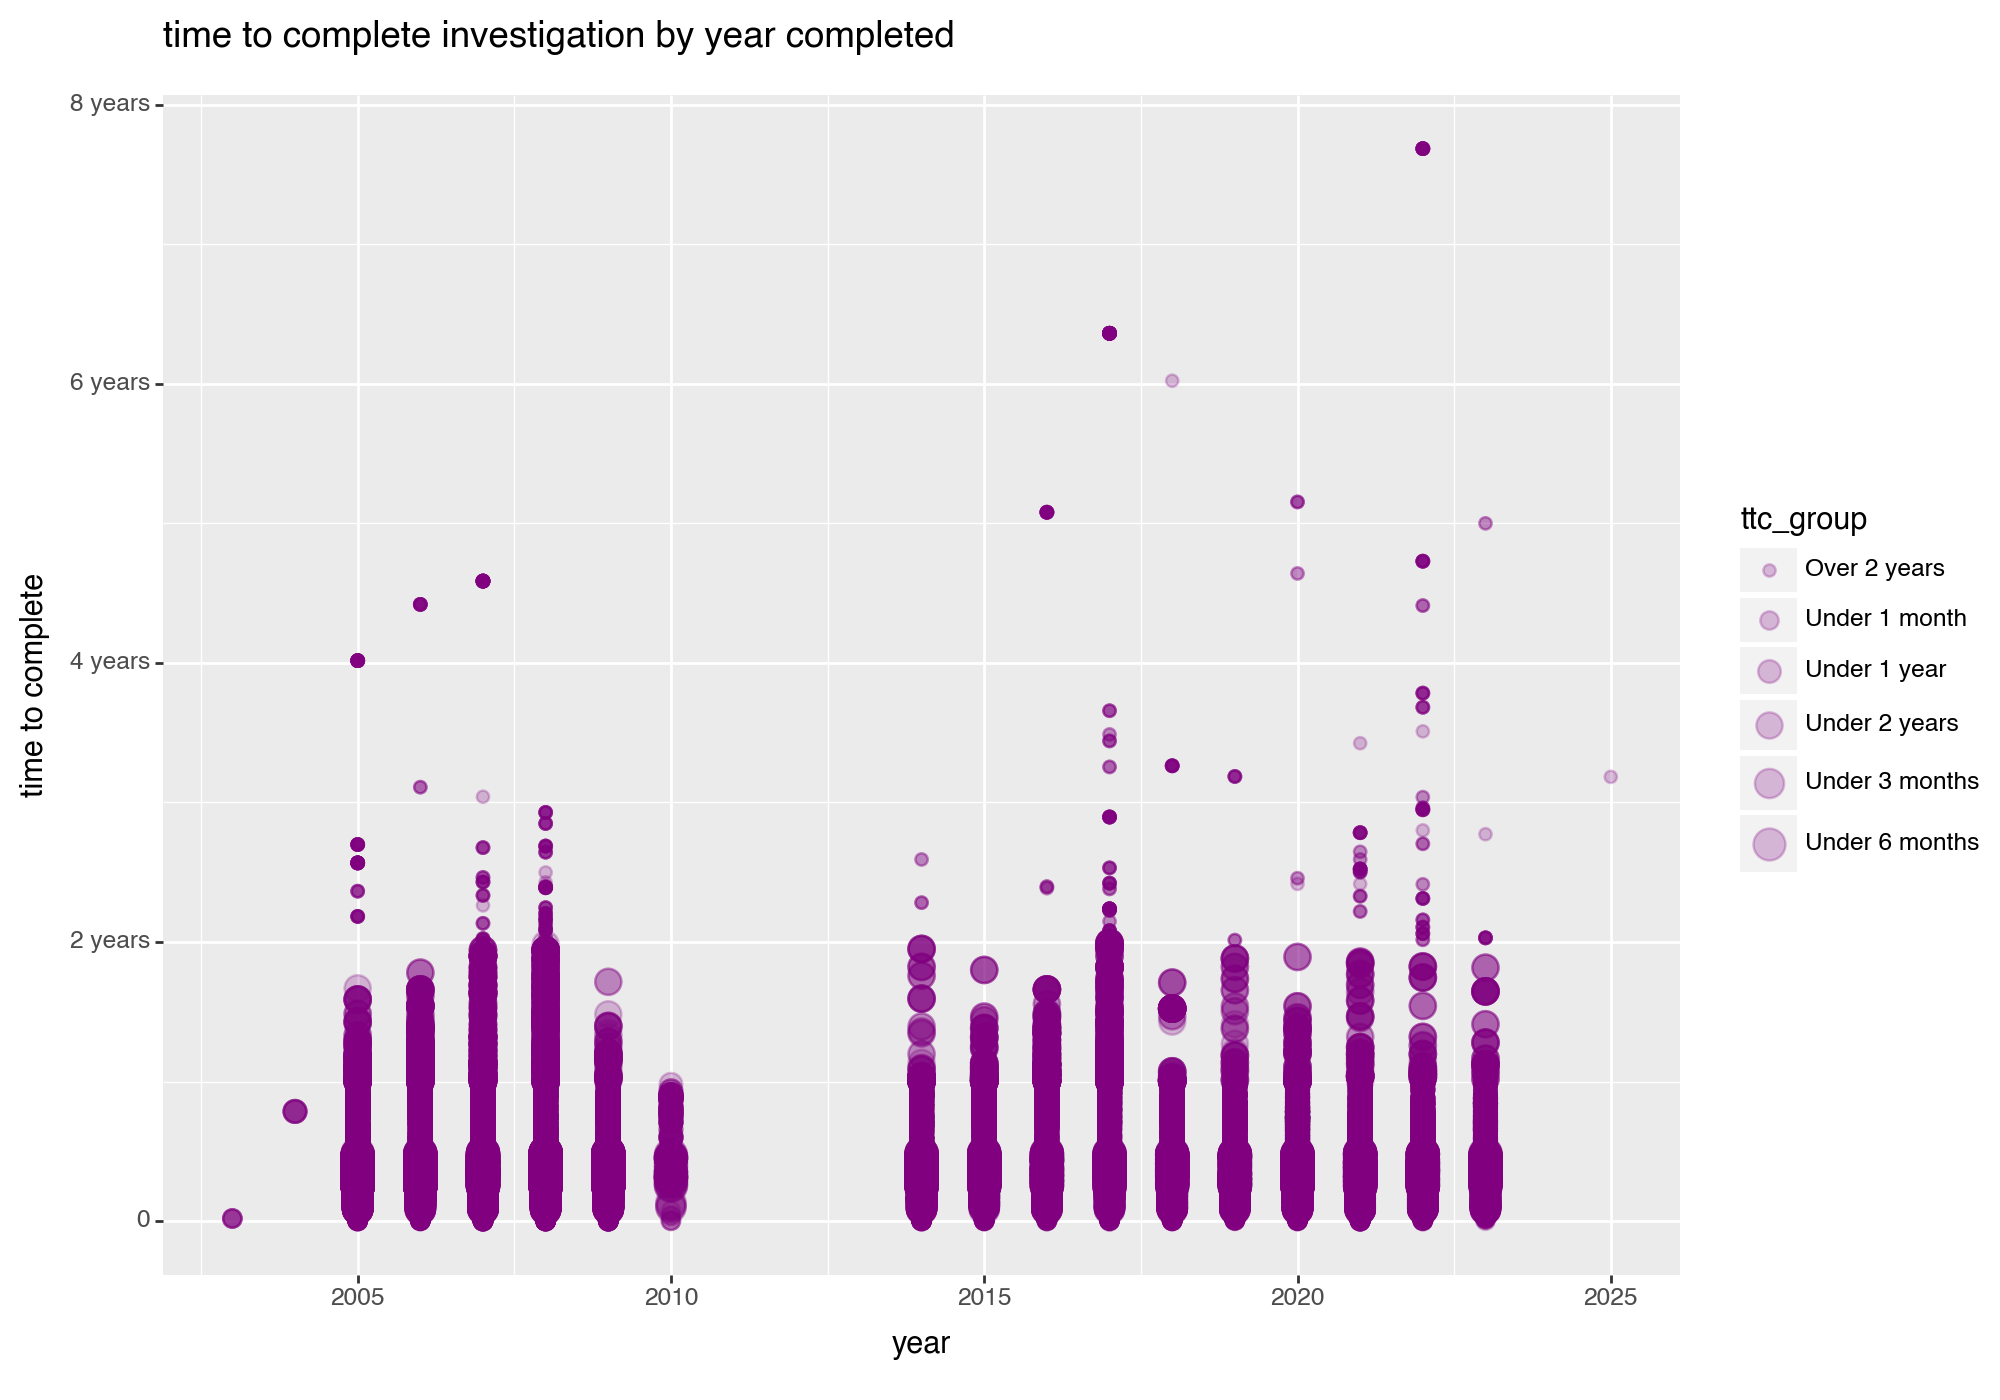

<Figure Size: (1000 x 700)>

In [33]:
chart = ggplot(data=less, mapping=aes(x="year_completed", y="time_to_complete", size="ttc_group"))
points = plotnine.geom_point(alpha=0.25, color='purple')
labels = plotnine.labs(x="year", y="time to complete", 
                       title="time to complete investigation by year completed", size="ttc_group")
theme_grammer = plotnine.theme(figure_size=(10,7))
scatter4 = chart + points + labels + theme_grammer
scatter4

/opt/homebrew/Caskroom/miniforge/base/lib/python3.11/site-packages/plotnine/utils.py:1183: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


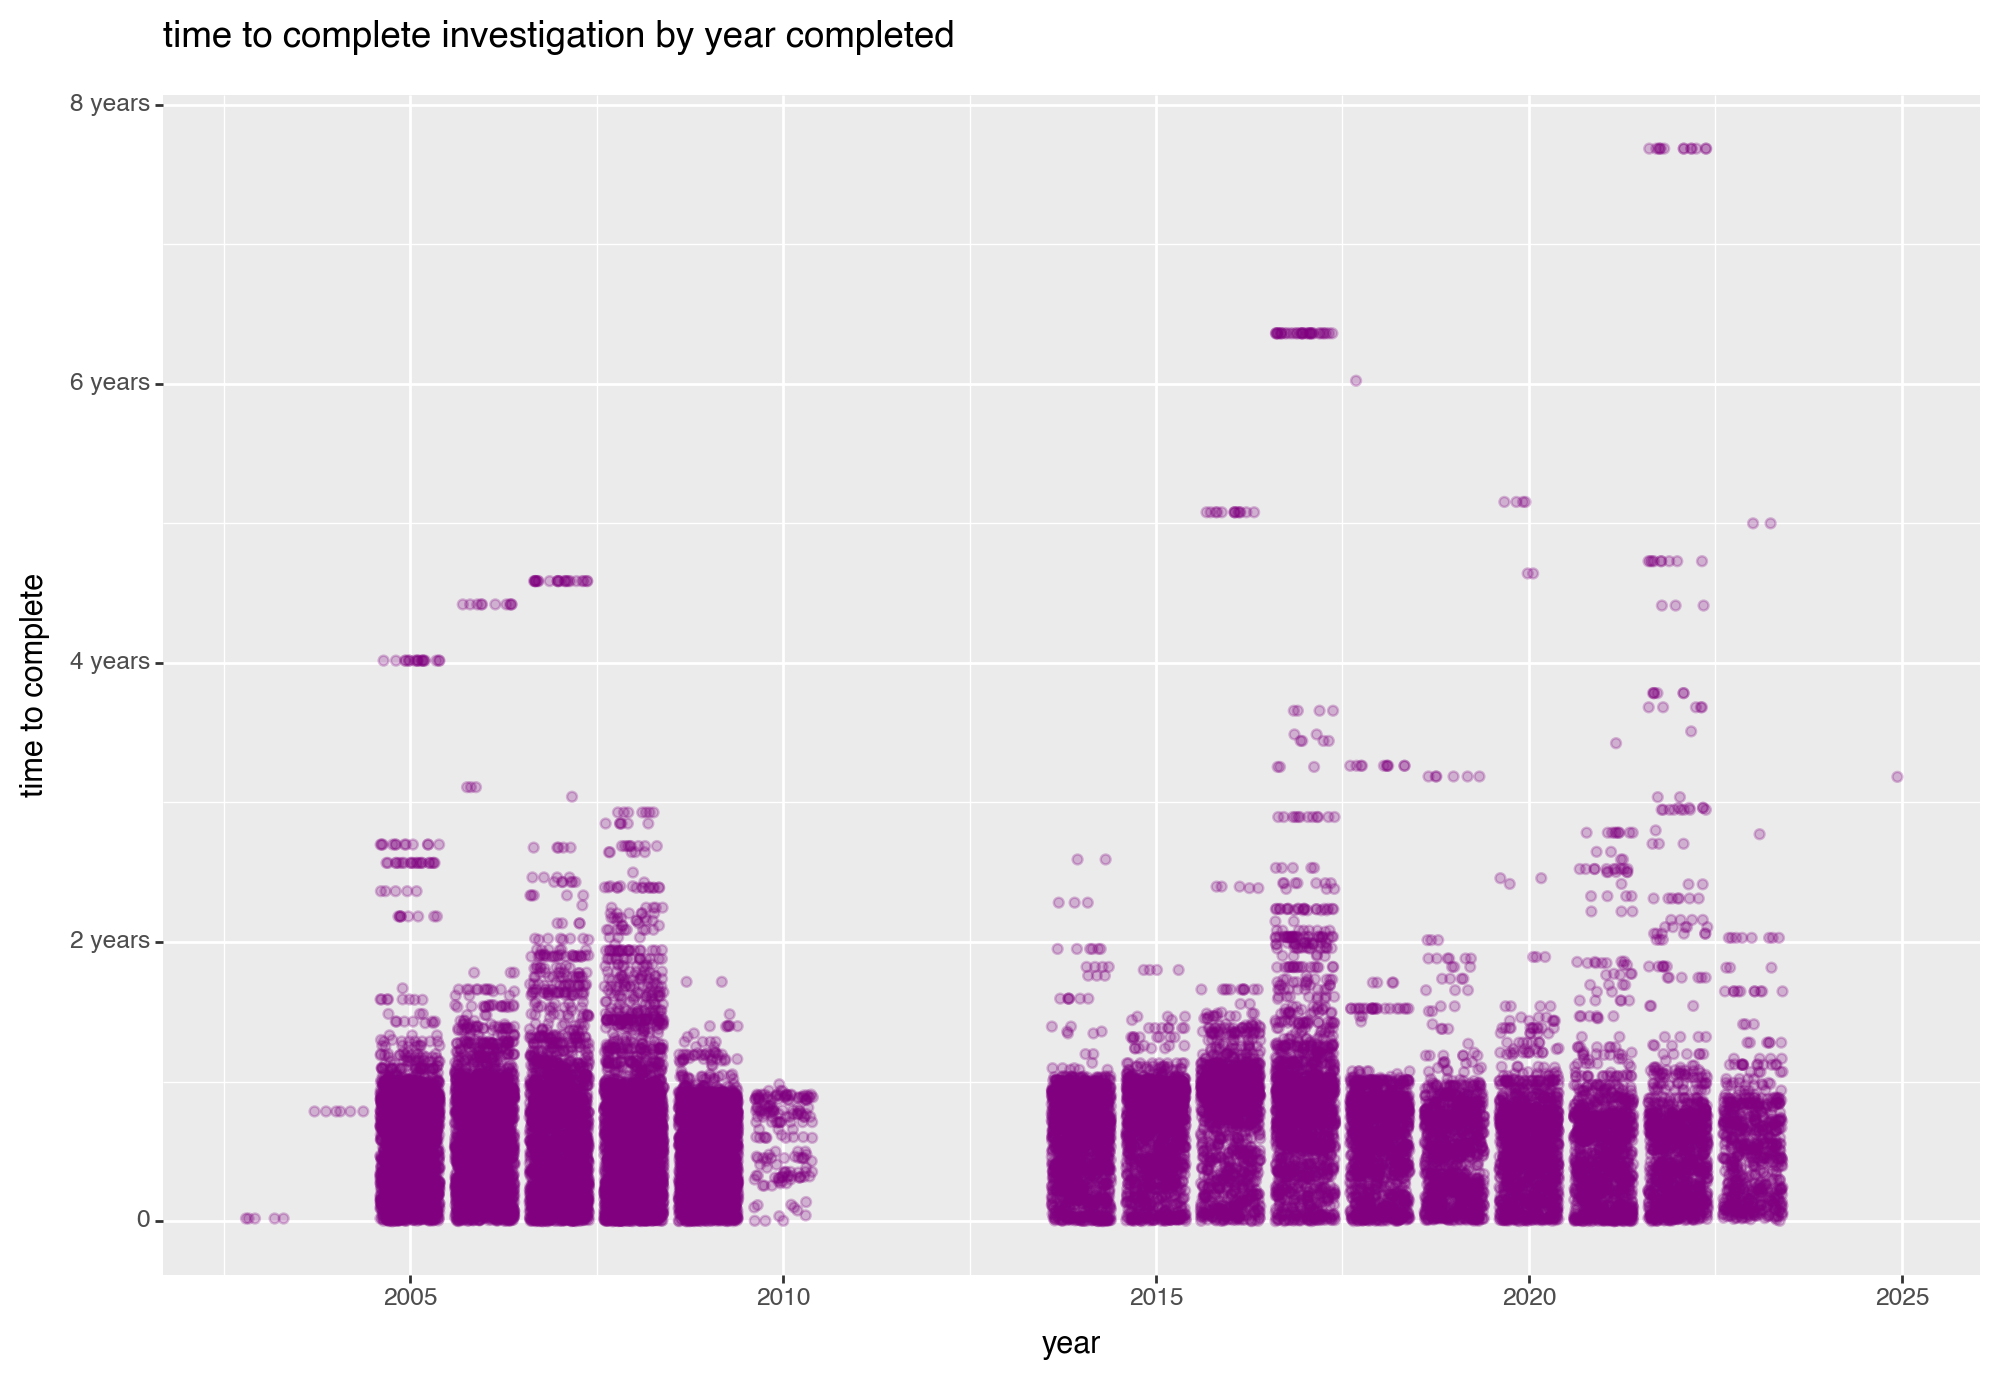

<Figure Size: (1000 x 700)>

In [34]:
chart = ggplot(data=less, mapping=aes(x="year_completed", y="time_to_complete"))
points = plotnine.geom_jitter(alpha=0.25, color='purple')
labels = plotnine.labs(x="year", y="time to complete", 
                       title="time to complete investigation by year completed")
theme_grammer = plotnine.theme(figure_size=(10,7))
scatter4 = chart + points + labels + theme_grammer
scatter4

## negative time to close??

In [35]:
complaints.loc[(complaints.ttc_group == 'NEGATIVE') & (~complaints.pdf_url.str.contains("June_Openness", regex=False)), 
['date_complained', 'date_completed', 'easy_date_complained', 'easy_date_completed', 'pdf_url']].values

KeyError: "['easy_date_complained', 'easy_date_completed'] not in index"

In [36]:
complaints.loc[(complaints.ttc_group == 'NEGATIVE') & (complaints.pdf_url.str.contains("June_Openness", regex=False)), 
['date_complained', 'date_completed', 'easy_date_complained', 'easy_date_completed', 'pdf_url']].values

KeyError: "['easy_date_complained', 'easy_date_completed'] not in index"

- these are definitely all typos. some are salvageable (for example, the set from the June 2023 report uses 2022 in the date completed field accidentally for some pages of some complaints), but some may be too difficult to recover (unknown true date complained)
- we can likely make informated corrections to the date_completed field most of the time using common sense and metadata, but highly unlikely date_complained can be corrected with the same methods (or at all)
- per TS, we can definitely salvage partial datestamps using any valid day/month/year combo, noting that it's probably day we will be missing (at least as far as date_completed goes)